# 2020-04-09 Regression

In this notebook, we will explore nonlinear regression and the Gauss-Newton optimization algorithm.

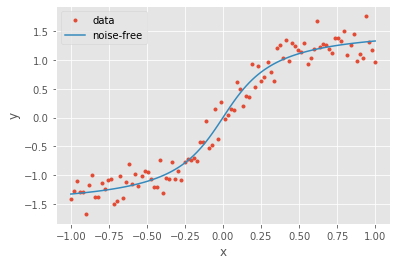

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def vander_chebyshev(x, n=None):
    if n is None:
        n = len(x)
    T = np.ones((len(x), n))
    if n > 1:
        T[:,1] = x
    for k in range(1,n-1):
        T[:,k+1] = 2 * x * T[:,k] - T[:,k-1]
    return T

def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (
        np.cos(np.linspace(-np.pi, 0, n)))

def gendata(n, sigma=.2, ptspace=np.linspace):
    x = ptspace(-1, 1, n)
    return x, np.arctan(4*x) + np.random.randn(*x.shape) * sigma


plt.plot(*gendata(100), '.', label='data')
plt.plot(*gendata(100, 0), label='noise-free')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

## Linear least squares

Here we solve the linear least squares regression problem
$$ V(x) c \approx y $$
where is the Vandermonde matrix in the basis of Chebyshev polynomials
$$ V(x) = \Big[ T_0(x) \Big| T_1(x) \Big| T_2(x) \Big| \dotsb \Big] . $$

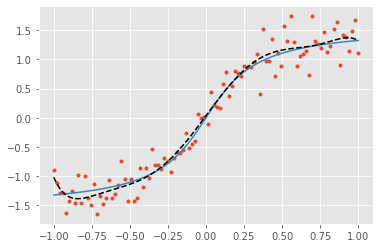

In [14]:
def regress_chebyshev(x, y, n):
    """Find the Chebyshev polynomial of degree n-1 that
    solves the least squares regression problem on the
    data (x,y) and evaluate the regressor at the points x.
    """
    V = vander_chebyshev(x, n)
    # Find c such that || V c - y || is minimized.  As we have
    # seen in class, this is equivalent to solving
    #   V^T (V c - y) = 0
    # or with Q R = V,
    #   R c = Q^T y.
    Q, R = np.linalg.qr(V)
    # Solve for c
    # YOUR CODE HERE
    min = np.linalg.lstsq(V, y, rcond = 0)
    c = min[0]
     
    return c, V @ c

x, y = gendata(100)
cpred_qr, ypred_qr = regress_chebyshev(x, y, 8)
plt.plot(x, y, '.')
plt.plot(*gendata(100, 0))
plt.plot(x, ypred_qr, '--k');

In [15]:
def test_interp_stability():
    x, y = gendata(50, 0, cosspace)
    _, ypred = regress_chebyshev(x, y, 50)
    maxerror = np.linalg.norm(ypred - y, np.inf)
    print('Interp: Maximum error', maxerror)
    assert maxerror < 1e-12

test_interp_stability()

def test_regress_accuracy():
    x, y = gendata(100, 0)
    _, ypred = regress_chebyshev(x, y, 50)
    maxerror = np.linalg.norm(ypred - y, np.inf)
    print('Regress: Maximum error', maxerror)
    assert maxerror < 1e-5
    
test_regress_accuracy()
print('Tests pass')

Interp: Maximum error 8.43769498715119e-15
Regress: Maximum error 1.6731847675421907e-07
Tests pass


## Gradient descent

We consider the algorithm

$$ c_{k+1} = c_k - \gamma \nabla_c L(c_k) $$

for a simple "loss" function $L$.

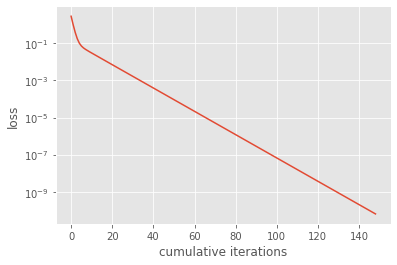

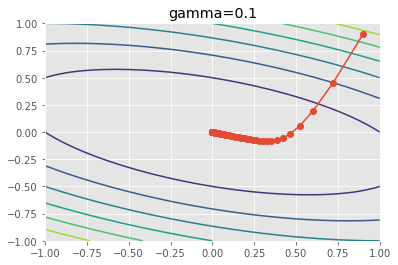

In [4]:
def grad_descent(loss, grad, c0, gamma=1e-3, tol=1e-5):
    """Minimize loss(c) via gradient descent with initial guess c0
    using learning rate gamma.  Declares convergence when norm of
    gradient is less than tol or after 500 steps.
    """
    c = c0.copy()
    chist, lhist = [], []
    for it in range(500):
        chist.append(c.copy())
        lhist.append(loss(c))
        g = grad(c)
        if np.linalg.norm(g) < tol:
            break
        c -= gamma * g
    return c, np.array(chist), np.array(lhist)

class quadratic_loss:
    """Test problem to give example of gradient descent."""
    def __init__(self):
        self.A = np.array([[1, 1], [1, 4]])
    def loss(self, c):
        return .5 * c @ self.A @ c
    def grad(self, c):
        return self.A @ c
    def hessian(self, c):
        return self.A

def test(gamma):
    q = quadratic_loss()
    c, chist, lhist = grad_descent(q.loss, q.grad, .9*np.ones(2), gamma=gamma)
    plt.semilogy(lhist)
    plt.ylabel('loss')
    plt.xlabel('cumulative iterations')

    plt.figure()
    l = np.linspace(-1, 1)
    x, y = np.meshgrid(l, l)
    z = [q.loss(np.array([x[i,j], y[i,j]])) for i in range(50) for j in range(50)]
    plt.contour(x, y, np.reshape(z, x.shape))
    plt.plot(chist[:,0], chist[:,1], 'o-')
    plt.title('gamma={}'.format(gamma))
    
test(.1)

## Numerical gradients

The gradient can be computed by numerically differentiating the loss function using forward differences
$$ \frac{\partial L(\mathbf c; x,y)}{\partial c_i} = \nabla L(c; x,y) \cdot \mathbf e_i \approx \frac{L(\mathbf c + h \mathbf e_i; x, y) - L(\mathbf c; x, y)}{h} $$
or centered differences
$$ \frac{\partial L(\mathbf c; x,y)}{\partial c_i} = \nabla L(c; x,y) \cdot \mathbf e_i \approx \frac{L(\mathbf c + h \mathbf e_i; x, y) - L(\mathbf c - h \mathbf e_i; x, y)}{2h} $$
for each $i$, where $c_i$ is component $i$ of the vector $\mathbf c$, $\mathbf e_i$ is the $i$th column of the identity, and $h$ is some small differencing parameter.
Note that you will need to evaluate the loss function once or twice (depending on which formula you use) per parameter $c_i$ (or equivalently, direction $\mathbf e_i$).

In [5]:
def fdgrad(loss, c):
    """Compute the gradient of the loss function with respect to
    each component of c. The result should be a vector with the same
    length as c.  Choose whichever of the two schemes above is most
    accurate and an appropriate differencing parameter h.
    """
    grad = np.zeros_like(c)
    # Use differencing to compute each entry grad[i].
    # YOUR CODE HERE
    x = np.identity(len(c))
    i = 0
    while i != len(c):
        h = 0.001
        v1 = (c + (x[i] * h))
        v2 = (c - (x[i] * h))
        totaloss = (loss(v1) - loss(v2))
        grad[i] = totaloss / (h*2)
        i += 1
    return grad

q = quadratic_loss()
fdgrad(q.loss, 0.9*np.ones(2))

array([1.8, 4.5])

In [6]:
def test_quadratic(c):
    q = quadratic_loss()
    c = np.array(c)
    print('Accuracy of gradient', fdgrad(q.loss, c) - q.grad(c))
    assert np.allclose(fdgrad(q.loss, c), q.grad(c), rtol=1e-9), "fdgrad is not accurate enough"

test_quadratic([1.5, 1])
test_quadratic([-0.3, 2.5])
print('Tests pass')

Accuracy of gradient [-4.97379915e-13 -3.83693077e-13]
Accuracy of gradient [ 2.01616501e-13 -4.01456646e-13]
Tests pass


## Solving the polynomial model

Now we demonstrate solving the polynomial regression (using the Chebyshev basis) using gradient descent.  For this, we write a loss function
$$ L(c; x,y) = \frac 1 2 \lVert V(x) c - y \rVert^2 $$
and associated gradient
$$ \nabla_c L(c; x,y) = \big[ V(x) c - y \big]^T V . $$

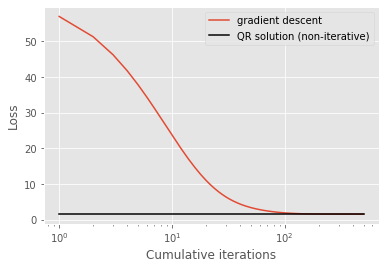

In [7]:
class chebyshev_loss:
    def __init__(self, x, y, n):
        self.V = vander_chebyshev(x, n)
        self.y = y
        self.n = n
        
    def init(self):
        return np.zeros(self.n)
    
    def fmodel(self, c):
        """Model f(x,c) evaluated at points x."""
        return self.V @ c
    
    def fgrad(self, c):
        """Derivative of fmodel with respect to c."""
        return self.V

    def loss(self, c):
        r = self.fmodel(c) - y
        return 0.5 * (r @ r)
    
    def grad(self, c):
        r = self.fmodel(c) - y
        return r.T @ self.V
    
cheb = chebyshev_loss(x, y, 8)
c, _ , lhist = grad_descent(cheb.loss, cheb.grad, np.zeros(8))

itnum = np.arange(1, 1+len(lhist))
plt.semilogx(itnum, lhist, label='gradient descent')
plt.semilogx(itnum, 0*lhist + cheb.loss(cpred_qr), 'k', label='QR solution (non-iterative)')
plt.ylabel('Loss')
plt.xlabel('Cumulative iterations')
plt.legend();

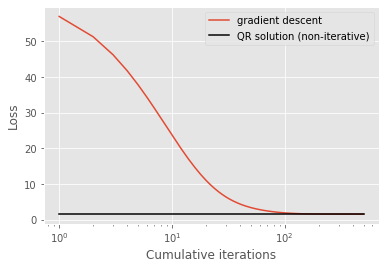

In [8]:
cheb4 = chebyshev_loss(x, y, 4)

# We can use fdgrad to avoid needing to hand-code the gradient

def loss_fdgrad(loss):
    """Returns a function that computes the gradient of loss.
    """
    def f(c):
        return fdgrad(loss, c)
    return f

# Note that we no longer use cheb.grad
c, _ , lhist = grad_descent(cheb.loss, loss_fdgrad(cheb.loss), np.zeros(8))

itnum = np.arange(1, 1+len(lhist))
plt.semilogx(itnum, lhist, label='gradient descent')
plt.semilogx(itnum, 0*lhist + cheb.loss(cpred_qr), 'k', label='QR solution (non-iterative)')
plt.ylabel('Loss')
plt.xlabel('Cumulative iterations')
plt.legend();

## Newton's method

Newton's method can also be used for optimization by solving the first order optimality conditions
$$ g(c) = \nabla_c L(c; x, y) = 0 $$
as a rootfinding problem in `len(c)` variables.
(Line searches and other globalization techniques are usually specialized for optimization, but the algebraic equations are the same as for rootfinding.)

Now that we are working in multiple dimensions, we build a linear model (truncated Taylor series) to approximate $g(c)$ near our current guess $c_0$,
$$ \tilde g_{c_0}(c) = g(c_0) + \underbrace{\big[ \nabla_c g \big]_{c_0}}_{H} (c - c_0) $$
where the square matrix $H$ is called the Hessian and is the derivative of each entry in $g(c)$ with respect to each component of $c$.  Specifically, the entries of the Hessian are
$$ H_{[i,j]} = \frac{\partial g(c)_{[i]}}{\partial c_{[j]}} $$
where the subscript square brackets are array indexing.
Solving $\tilde g(c) = 0$ amounts to solving the linear equation
$$ H \delta c = -g(c_0) $$
for $\delta c$, and then updating $c = c_0 + \delta c$, thus the Newton iteration is
$$ c_{k+1} = c_k - H^{-1} g(c_k) $$
starting with initial guess $c_0$.

Note that there is no "learning rate" parameter to tune.

In [9]:
def newton(loss, grad, hessian, c0, tol=1e-5):
    """Minimize loss(c) via Newton's method with initial guess c0.
    Declares convergence when norm of gradient is less than tol or
    after 500 steps.
    """
    c = c0.copy()
    chist = []
    lhist = []
    for it in range(500):
        chist.append(c.copy())
        lhist.append(loss(c))
        g = grad(c)
        if np.linalg.norm(g) < tol:
            break
        H = hessian(c)
        c -= np.linalg.solve(H, g)
    return c, np.array(chist), np.array(lhist)

def test():
    """Test convergence of Newton's method for minimizing the quadratic loss."""
    q = quadratic_loss()
    c, chist, lhist = newton(q.loss, q.grad, q.hessian, np.ones(2))
    for i in range(len(chist)):
        print('Iteration {}: c={}, loss={}'.format(i, chist[i], lhist[i]))

test()

Iteration 0: c=[1. 1.], loss=3.5
Iteration 1: c=[0. 0.], loss=0.0


* This converged in just one iteration!
* Why?  (Please discuss on Piazza.)

## Approximating the Hessian

The least squares loss function
$$ L(c; x,y) = \frac 1 2 \lVert f(x,c) - y \rVert^2 $$
for model $f(x,c)$ has gradient
$$ g(c) = \nabla_c L(c; x,y) = \big( f(x,c) - y \big)^T \nabla_c f(x,c) $$
and thus the Hessian is
$$ H = \nabla_c g(c) = \nabla_c^2 L(c; x,y) = \underbrace{\big( \nabla_c f(x,c) \big)^T \nabla_c f(x,c)}_{H_{GN}} + \big( f(x,c) - y \big)^T \nabla_c^2 f(x,c) . $$
The second term involves the second derivative $\nabla_c^2 f(x,c)$, which is not needed to compute the gradient $g(c)$ and is often complicated to compute.  The Gauss-Newton algorithm is Newton's method where the true Hessian $H$ is approximated by $H_{GN}$.

In [10]:
def gaussnewton(fmodel, fgrad, y, c0, tol=1e-5):
    """Minimize loss(c) = norm(fmodel(c) - y)/2 by the Gauss-Newton
    method with initial guess c0.  Declares convergence when norm of
    gradient is less than tol or after 500 steps.
    """
    c = c0.copy()
    chist, lhist = [], []
    for it in range(500):
        residual = fmodel(c) - y
        loss = 0.5 * residual @ residual
        chist.append(c.copy())
        lhist.append(loss)
        V = fgrad(c)
        g = residual @ V
        if np.linalg.norm(g) < tol:
            break
        # Solve for the Gauss-Newton step and update c.  The following
        # should be the Gauss-Newton version of the last two lines of
        # the analogous loop newton() above.
        # YOUR CODE HERE
        h = V.T @ V
        c -= np.linalg.solve(h, g)
    return c, np.array(chist), np.array(lhist)

In [11]:
def test_gn():
    cheb = chebyshev_loss(x, y, 8)
    c, chist, lhist = gaussnewton(cheb.fmodel, cheb.fgrad, y, np.ones(8))
    print('loss history', lhist)
    assert len(lhist) == 2, "Unexpected number of iterations"
    assert np.allclose(c, cpred_qr), "Incorrect solution c"
    
test_gn()
print('Tests pass')

loss history [126.38008847   1.57730974]
Tests pass


### What happened?

We ignored the second derivative term and yet the algorithm still converged in one iteration.  Why?  (Discuss on Piazza).

## Exponential functions

Now we use an exponential model
$$ f(x,c) = \frac{c_0 - e^{c_1 x}}{1 + e^{c_2 x}} . $$
You will need to differentiate this model with respect to $c$, resulting in a matrix
$$ \nabla_c f(x,c) = \Big[ \frac{\partial f(x,c)}{\partial c_0} \Big| \frac{\partial f(x,c)}{\partial c_1} \Big| \frac{\partial f(x,c)}{\partial c_2} \Big] .$$
This will provide all the necessary information to run both Gradient descent and the Gauss-Newton algorithms.

In [12]:
class expr_loss:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.n = 3
        
    def init(self):
        return np.ones(self.n)
    
    def fmodel(self, c):
        """Model f(x,c) evaluated at points x."""
        x = self.x
        return (c[0] - np.exp(c[1]*x)) / (1 + np.exp(c[2]*x))
    
    def fgrad(self, c):
        """Derivative of fmodel with respect to c."""
        x = self.x
        # Implement the gradient of fmodel(c) with respect to c.
        # The result will be a matrix of shape (len(x), len(c)).
        # You could construct it by code along the lines of
        #    return np.array([column 0 expression,
        #                     column 1 expression,
        #                     column 2 expression]).T
        # YOUR CODE HERE
        d1 = 1 / (np.exp(c[2] * x) + 1)
        d2 = -(x * np.exp(c[1] * x)) / (np.exp(c[2] * x) + 1)
        d3 = -((x * np.exp(c[2] * x)) * (c[0] - np.exp(c[1] * x))) / ((np.exp(c[2] * x) + 1) **2)
        return np.array([d1, d2, d3]).T

    def loss(self, c):
        r = self.fmodel(c) - self.y
        return 0.5 * (r @ r)
    
    def grad(self, c):
        r = self.fmodel(c) - self.y
        return r.T @ self.fgrad(c)

Tests pass


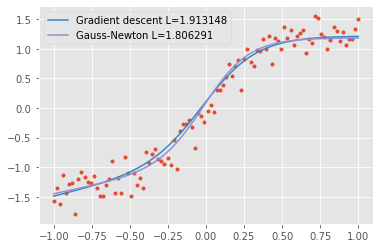

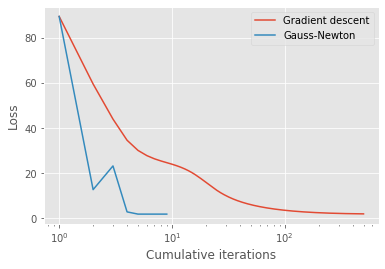

In [13]:
def test_expr():
    expr = expr_loss(x, y)
    c0 = expr.init()
    c_gd, chist_gd, lhist_gd = grad_descent(expr.loss, expr.grad, expr.init(), gamma=2e-2)
    c_gn, chist_gn, lhist_gn = gaussnewton(expr.fmodel, expr.fgrad, y, expr.init())
    plt.plot(x, y, '.')
    plt.plot(x, expr.fmodel(c_gd), label='Gradient descent L={:5f}'.format(lhist_gd[-1]))
    plt.plot(x, expr.fmodel(c_gn), label='Gauss-Newton L={:5f}'.format(lhist_gn[-1]))
    plt.legend()
    
    plt.figure()
    plt.semilogx(np.arange(1,1+len(lhist_gd)), lhist_gd, label='Gradient descent')
    plt.semilogx(np.arange(1,1+len(lhist_gn)), lhist_gn, label='Gauss-Newton')
    plt.ylabel('Loss')
    plt.xlabel('Cumulative iterations')
    plt.legend()
    assert lhist_gn[-1] < lhist_gd[-1]
    assert len(lhist_gn) < 20
    assert lhist_gd[-1] < 10

test_expr()
print('Tests pass')